In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

Chapter 3 exercise 3, a hierarchical version of the tips example from Chapter 2, by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.

Retrieve the example from chapter 2:

In [7]:
tips = pd.read_csv("../code/data/tips.csv")

categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample(random_seed=4591)
az.summary(idata_cg, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[Thur],2.78,0.15,2.49,3.06,0.0,0.0,4186.29,2913.62,1.0
μ[Fri],2.77,0.25,2.28,3.22,0.0,0.0,4621.06,2799.59,1.0
μ[Sat],3.00,0.15,2.72,3.28,0.0,0.0,3898.08,2815.31,1.0
μ[Sun],3.26,0.15,2.97,3.52,0.0,0.0,4125.59,2576.70,1.0
σ[Thur],1.16,0.12,0.93,1.37,0.0,0.0,4415.38,2942.90,1.0
σ[Fri],1.11,0.21,0.75,1.48,0.0,0.0,4372.62,3082.06,1.0
σ[Sat],1.44,0.12,1.22,1.67,0.0,0.0,3933.41,3084.99,1.0
σ[Sun],1.26,0.11,1.05,1.48,0.0,0.0,4185.37,3133.66,1.0


Multi-level model:

In [32]:
with pm.Model(coords=coords) as comparing_groups_h:
    mu_h = pm.HalfNormal("mu_h", sigma=5)
    sigma_mu_h = pm.Exponential("sigma_mu_h",  1)
    z_mu = pm.Normal("z_mu", mu=0, sigma=1, dims="days")
 
    μ = pm.Deterministic("μ", mu_h + z_mu * sigma_mu_h, dims = "days")
    
    # Note: i found that partial pooling sigma didnt do much to help here.
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg_h = pm.sample(target_accept = 0.95,random_seed=4591)
az.summary(idata_cg_h, round_to=2, var_names=["~z_mu", "~z_sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_h, sigma_mu_h, z_mu, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['z_sigma'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_h,2.98,0.19,2.58,3.33,0.01,0.01,1015.82,743.87,1.0
sigma_mu_h,0.28,0.22,0.00,0.66,0.01,0.01,890.95,865.87,1.0
σ[Thur],1.19,0.13,0.96,1.43,0.00,0.00,2925.60,2683.83,1.0
σ[Fri],1.15,0.21,0.81,1.57,0.00,0.00,2787.91,1965.60,1.0
σ[Sat],1.44,0.12,1.22,1.67,0.00,0.00,3080.15,2139.80,1.0
σ[Sun],1.23,0.11,1.03,1.44,0.00,0.00,3114.26,2397.32,1.0
μ[Thur],2.86,0.14,2.60,3.13,0.00,0.00,2476.84,3021.62,1.0
μ[Fri],2.89,0.20,2.48,3.24,0.00,0.00,2464.22,2739.77,1.0
μ[Sat],3.00,0.13,2.76,3.25,0.00,0.00,3749.67,3162.35,1.0
μ[Sun],3.16,0.14,2.90,3.43,0.00,0.00,2061.57,2727.09,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

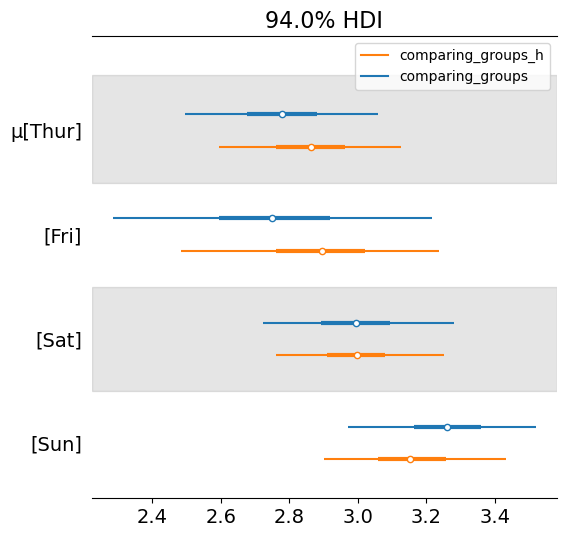

In [33]:
az.plot_forest([idata_cg, idata_cg_h], model_names=["comparing_groups", "comparing_groups_h"],
               combined = True, var_names=["μ"], figsize=(6, 6))

The hierarchical model has little effect, just a slight pulling toward teh group mean 2.9, except for friday where there were fewer samples

In [28]:
tips.groupby("day").size()

day
Fri     19
Sat     87
Sun     76
Thur    62
dtype: int64